Install AGAMA library: https://github.com/GalacticDynamics-Oxford/Agama/tree/master
1. Create a new conda environment: "conda create -n agama python=3.9 numpy"
2. Download file to Vera, unzip, and follow the installation process via GitHub ("python3 setup.py install --user" - replying "Y" when prompted

Submit job-test.sh: "sbatch job-test.sh"

If finishes running and creates "hernquist_nb" successfully, proceed.

### Unit Conversion

#### MP-Gadget
- Position: kpc
- Velocity: km/s
- Mass: 1e10 Msun

#### AGAMA
- Position: pc
- Velocity: 0.0656 km/s
- Mass: Msun

Use LR/HR Text to BigFile Processing to get valid file type to be used in AGAMA job.

Submit job to Vera using paramfile_single_halo.gadget and run.sh

----------------------------------------------

### LR/HR Text to BigFile Processing

In [2]:
import numpy as np
import sys
import os
import struct
from bigfile import BigFile

In [3]:
msun_mks = 1.989e30
pc_mks = 3.086e16
grav_mks = 6.67e-11
km_mks = 1e3

In [4]:
# User-defined value for the number of LR/HR pairs to be processed.
num_pairs = 1
nbh = 1
rinit = 5

# Choose BH mass:
mbh = 5e-3

# Choose direction of sinking BH:
clockwise = True

# Choose fraction of orbital velocity
vfrac = 0.5

Lbox = 2000
offset = 1000
LR = 20000
HR = 10*LR

In [6]:
print("Total number of particles in HR:",HR)

Total number of particles in HR: 200000


In [7]:
for i in range(1, num_pairs + 1):
    for res in ['high']:
        if res == 'low':
            npart = LR
            
            ofile = '/hildafs/projects/phy200018p/share/calvin_2023/halo_bh/output'
            ofile = ofile + '/PART_000'
            if not os.path.exists(ofile):
                os.makedirs(ofile)
            
            ifile = '/hildafs/home/hoffmanc/Agama-master/LRHR_pairs/input/LR'
            ifile = ifile + '/LR_input_' + str(i)
            ifile = np.loadtxt(ifile)
            
        else:
            npart = HR
            
            ofile = '/hildafs/projects/phy200018p/share/calvin_2023/halo_bh/output'
            ofile = ofile + '/PART_000'
            if not os.path.exists(ofile):
                os.makedirs(ofile)
            
            ifile = '/hildafs/home/hoffmanc/scratch/output/HR/HR_input_1'
            # ifile = '/hildafs/home/hoffmanc/Agama-master/LRHR_pairs/input/HR/HR_input_1'
            # ifile = ifile + '/HR_input_' + str(i)
            ifile = np.loadtxt(ifile)
        
        ifile = [tuple(row) for row in ifile]
            
        ifile = np.array(ifile, dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'),
                                           ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('mass', '<f8')])
        assert len(ifile) == npart
            
        positions = [[curr[0]*1e-3,curr[1]*1e-3,curr[2]*1e-3] for curr in ifile]
        positions.append([rinit, 0., 0.])
        positions = np.array(positions)
        positions += offset

        pos_mags = np.array([np.sqrt((curr[0]-offset)**2 + (curr[1]-offset)**2 + (curr[2]-offset)**2) for curr in positions])
        mask = pos_mags < rinit
        pos_mags = pos_mags[mask]
        
        mdm = ifile['mass'][0]/1e10
        
        Menc = (len(pos_mags) * mdm) * 1e10 * msun_mks
            
        rr_mks = rinit * 1e3 * pc_mks

        if rinit > 0:
            v_circ = np.sqrt(grav_mks * Menc / rr_mks)
            v_circ /= km_mks
        else:
            v_circ = 0.

        if clockwise:
            bhvel = [0., -v_circ * vfrac / 0.0656, 0.]
        else:
            bhvel = [0., v_circ * vfrac / 0.0656, 0.]
        
        velocities = [[curr[3],curr[4],curr[5]] for curr in ifile]
        velocities.append(bhvel)
        velocities = np.array(velocities)
        velocities *= 0.0656

        ids = [i for i in range(npart)]
        ids.append(5e10)
        ids = np.array(ids)

        print(max(ids))
        
        masses = [curr[6]/1e10 for curr in ifile]
        masses.append(mbh)
        masses = np.array(masses)
            
        with BigFile(ofile) as ff:
            ff.create_from_array('1/Position', positions)

            ff.create_from_array('1/Velocity', velocities)

            ff.create_from_array('1/ID', ids)

            ff.create_from_array('1/Mass', masses)
            
        with BigFile(ofile) as ff:           
            nbh = 0
            
            with ff.create('Header') as bb:
                bb.attrs['BoxSize'] = Lbox
                bb.attrs['HubbleParam'] = 1.
                bb.attrs['MassTable'] = np.array([0., mdm, 0., 0., 0., mbh])
                bb.attrs['Omega0'] = 0.3
                bb.attrs['OmegaBaryon'] = 0.046
                bb.attrs['OmegaLambda'] = 0.7
                bb.attrs['Time'] = 0.001
                bb.attrs['TimeIC'] = 0.001
                bb.attrs['TotNumPart'] = np.array([0, npart+1, 0, 0, 0, nbh], dtype=np.uint)
                bb.attrs['UsePeculiarVelocity'] = 1
                bb.attrs['Seed'] = 0
    
    print('------------------------------')
    print('Finished writing LR/HR pair:', i)
    print('------------------------------')

50000000000.0
------------------------------
Finished writing LR/HR pair: 1
------------------------------


## Sanity Checks

In [8]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap("Set2")

In [9]:
og_file = np.loadtxt('/hildafs/home/hoffmanc/scratch/output/HR/HR_input_1')
new_file = BigFile("/hildafs/projects/phy200018p/share/calvin_2023/halo_bh/output/PART_000")

In [10]:
og_file[:,0]*1e-4

array([-2.8658826 , -0.12570017, -1.0505968 , ..., -1.4098854 ,
       -1.5917346 , -2.0382537 ])

In [11]:
new_file.keys()

['1/ID',
 '1/Mass',
 '1/Position',
 '1/Velocity',
 '5/BlackholeAccretionRate',
 '5/BlackholeDensity',
 '5/BlackholeMass',
 '5/BlackholeMinPotPos',
 '5/BlackholeMseed',
 '5/BlackholeMtrack',
 '5/BlackholeProgenitors',
 '5/BlackholeSwallowID',
 '5/BlackholeSwallowed',
 '5/Generation',
 '5/ID',
 '5/Mass',
 '5/Position',
 '5/SmoothingLength',
 '5/StarFormationTime',
 '5/Swallowed',
 '5/Velocity',
 'Header']

In [12]:
new_file['1/Velocity'][:][:,0]

array([  71.08917184,  -70.88282704,   -3.84766973, ...,  129.43474992,
       -134.82255664,    0.        ])

In [13]:
new_file['5/Position'][:][0]

1005.0

### Position Scatter Plot

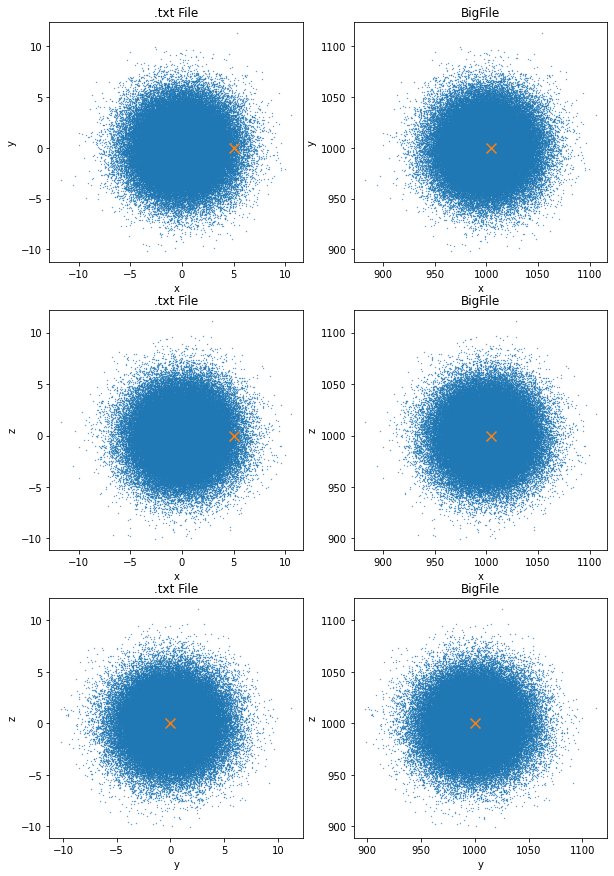

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(10,15))

ax[0][0].scatter(og_file[:,0]*1e-4,og_file[:,1]*1e-4,s=0.1)
ax[0][0].scatter(5,0,s=100,marker='x')
ax[0][1].scatter(new_file['1/Position'][:][:,0],new_file['1/Position'][:][:,1],s=0.1)
ax[0][1].scatter(new_file['5/Position'][:][0],new_file['5/Position'][:][1],s=100,marker='x')

ax[0][0].set(xlabel='x',ylabel='y',title='.txt File')
ax[0][1].set(xlabel='x',ylabel='y',title='BigFile')

ax[1][0].scatter(og_file[:,0]*1e-4,og_file[:,2]*1e-4,s=0.1)
ax[1][0].scatter(5,0,s=100,marker='x')
ax[1][1].scatter(new_file['1/Position'][:][:,0],new_file['1/Position'][:][:,2],s=0.1)
ax[1][1].scatter(new_file['5/Position'][:][0],new_file['5/Position'][:][2],s=100,marker='x')

ax[1][0].set(xlabel='x',ylabel='z',title='.txt File')
ax[1][1].set(xlabel='x',ylabel='z',title='BigFile')

ax[2][0].scatter(og_file[:,1]*1e-4,og_file[:,2]*1e-4,s=0.1)
ax[2][0].scatter(0,0,s=100,marker='x')
ax[2][1].scatter(new_file['1/Position'][:][:,1],new_file['1/Position'][:][:,2],s=0.1)
ax[2][1].scatter(new_file['5/Position'][:][1],new_file['5/Position'][:][2],s=100,marker='x')

ax[2][0].set(xlabel='y',ylabel='z',title='.txt File')
ax[2][1].set(xlabel='y',ylabel='z',title='BigFile')


plt.show()

## Velocity Histogram

In [16]:
og_velos = np.sqrt((og_file[:,3]/0.0656)**2 + (og_file[:,4]/0.0656)**2 + (og_file[:,5]/0.0656)**2)
new_velos = np.sqrt((new_file['1/Velocity'][:][:,0])**2 + (new_file['1/Velocity'][:][:,1])**2 + (new_file['1/Velocity'][:][:,2])**2)

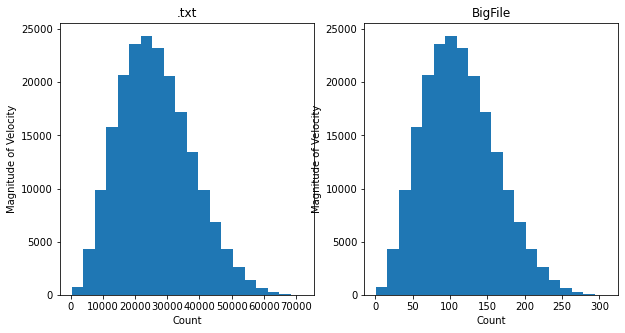

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(og_velos,bins=20)
ax[1].hist(new_velos,bins=20)

ax[0].set(xlabel='Count', ylabel='Magnitude of Velocity', title='.txt')
ax[1].set(xlabel='Count', ylabel='Magnitude of Velocity', title='BigFile')

plt.show()

## Density Profile

In [18]:
og_distance = np.sqrt((og_file[:,0]*1e-4)**2 + (og_file[:,1]*1e-4)**2 + (og_file[:,2]*1e-4)**2)
new_distance = np.sqrt((new_file['1/Position'][:][:,0]-offset)**2 + (new_file['1/Position'][:][:,1]-offset)**2 + (new_file['1/Position'][:][:,2]-offset)**2)

og_distances = np.linspace(min(og_distance),max(og_distance+0.1),num=20)
new_distances = np.linspace(min(new_distance),max(new_distance+0.1),num=20)

In [19]:
og_mass, new_mass = [], []

for dist in og_distances:
    mask = og_distance < dist
    tmp = og_distance[mask]
    
    og_mass.append(len(tmp)*og_file[0][6]*msun_mks)
    
for dist in new_distances:
    mask = new_distance < dist
    tmp = new_distance[mask]
    
    new_mass.append(len(tmp)*mdm)

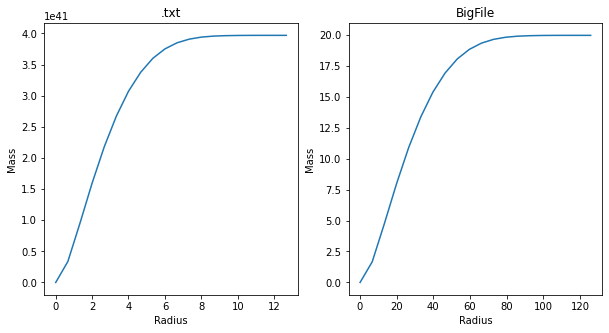

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(og_distances, og_mass)
ax[1].plot(new_distances, new_mass)

ax[0].set(xlabel='Radius',ylabel='Mass',title='.txt')
ax[1].set(xlabel='Radius',ylabel='Mass',title='BigFile')

plt.show()